In [1]:
import numpy as np
import math
import statistics
from sklearn import preprocessing
import networkx as nx
import matplotlib.pyplot as plt
import logging 

In [2]:
location_matrix=[]

with open('MandlCoords.txt', 'r') as f: 
    for line in f.readlines():
        location_matrix.append([float(x) for x in line.split()])
        
all_nodes = np.arange(len(location_matrix))
location_matrix       

[[1.0, 5.0],
 [1.0, 9.0],
 [3.0, 8.0],
 [4.5, 7.75],
 [2.75, 6.2],
 [0.8, 6.6],
 [4.6, 6.0],
 [7.0, 4.5],
 [5.5, 5.0],
 [8.5, 6.8],
 [5.8, 3.25],
 [3.8, 2.25],
 [1.3, 3.5],
 [5.25, 1.0],
 [6.7, 1.75]]

array([[45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333],
       [45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333],
       [45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333],
       [45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333],
       [45.76413333, 45.76413333, 45.76413333, 45.76413333, 45.76413333,
        45.76413333, 45.76413333, 45.76413333, 

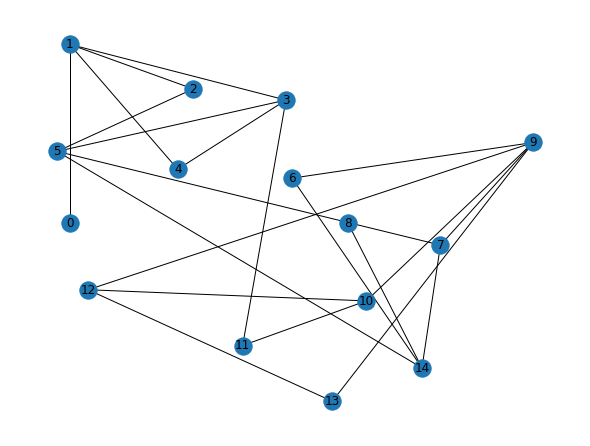

In [3]:
def scale_features(features : list) -> list:
    """scales feature to between 1 and 101
    takes the max number and add's 5% padding to it.
    the features are then transcribed to be percentages of this number
    scaled features to between 1 and 101 as we need to avoid have anything > 1 for the selection aglorithm
    
    Args:
        features (list): feature list

    Returns:
        list: scaled feature list
    """
    
    max_value = max(features)
    
    padded_max = max_value + ((max_value/100)*1)
    
    normalised_data = []
    for x in features: 
        normalised_data.append(round((x/padded_max)*100, 2)+1)
    
    return normalised_data
    

distance_matrix = []
connected_nodes = {}
with open('MandlTravelTimes.txt', 'r') as f: 
    for line in f.readlines()[::2]:
        row = []
        for x in line.split():
            element = float(x) if x != 'Inf' else 0
            row.append(element) 
        distance_matrix.append(row)
   

normalised_distance_matrix = np.reshape(scale_features(np.array(distance_matrix).flatten()), np.shape(distance_matrix))
#flip so we reward short distances in the selection equation
for index_r, row in enumerate(normalised_distance_matrix):
    for index_e, element in enumerate(row):
        if element != 1: 
            normalised_distance_matrix[index_r][index_e] = 102 - element 

all_row_means = []
for row in normalised_distance_matrix:
    row_mean = []
    for element in row: 
        if element != 1: 
            row_mean.append(element)
            
    all_row_means.append(statistics.mean(row_mean))
        
mean_of_none_zero_distance_elements = statistics.mean(all_row_means) 
pheromone_matrix = np.ones(np.shape(distance_matrix))*mean_of_none_zero_distance_elements

#normalise this 
busyness_matrix = []
with open('MandlDemand.txt', 'r') as f: 
    for line in f.readlines()[::2]:
        row = []
        for x in line.split():
            element = float(x)
            row.append(element) 
        busyness_matrix.append(row)
        
normalised_busyness_matrix = np.reshape(scale_features(np.array(busyness_matrix).flatten()), np.shape(busyness_matrix))
          
plt.figure(figsize=(8,6))
G = nx.Graph()
for index, pos in enumerate(location_matrix):
    G.add_node(index, pos=pos)
    
for index_r, row in enumerate(distance_matrix):
    node_to_node = []
    for index_e, element in enumerate(row):
        if element != 0: 
            node_to_node.append(index_e)
            G.add_edge(index_r, index_e)
    connected_nodes[index_r] = node_to_node
    
pos = nx.get_node_attributes(G, 'pos')    
nx.draw(G, pos=pos, with_labels=True)           
pheromone_matrix


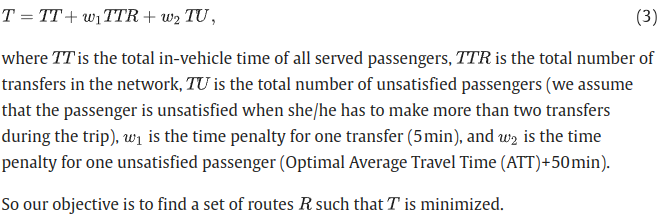


In [4]:
logger_file = 'ACO_logger.txt'

logging.basicConfig(filename=logger_file, format='%(asctime)s %(message)s', filemode='w')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [5]:
K = 4  # number of ants 
E = 0.997 # evapoartion rate
Q = 5 # pheromone laying rate 
A = 5 # pheremone weight
B = 1 # distance weight / route visibility 
Y = 1 # edge busyness weight

ROUTES = 4
STOP = 5
REWARD_SHORTEST = True
RANDOMISE_START = False
LOG = False
FOLDS = 1

ant_metadata = {}
#! will need to think of a way to pick start nodes
for ant in range(K):
    ant_metadata[ant] = {
        'start_node' : None, 
        'current_node' : None, 
        'path_tracker' : [],
        'path_fitness' : 0,
        'i_have_been_stuck_once_already' : False
    } 
    
route_tracker = {}
for route in range(ROUTES): 
    route_tracker[route] = []
    

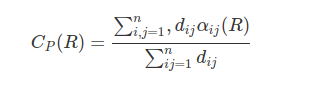

![image.png](attachment:image.png)

In [6]:
#for every node 



def find_start_node() -> int:
    """find the busyest node to start at

    Returns:
        int: start node
    """
    busyness = 0 
    start_node = None
    for node, list in enumerate(normalised_busyness_matrix):
        if sum(list) > busyness:
            busyness = sum(list)
            start_node = node
        
    return start_node


def pick_next_node(ant : int) -> int: 
    
    while True: 
        possible_nodes = [x for x in connected_nodes[ant_metadata[ant]['current_node']] if x not in ant_metadata[ant]['path_tracker']]
        #print(possible_nodes)
        
        if len(possible_nodes) > 0:
            break
        else: 
            if ant_metadata[ant]['i_have_been_stuck_once_already']:
                return -1
            else:
                #print(f'ant {ant} got stuck, flipping path')
                ant_metadata[ant]['i_have_been_stuck_once_already'] = True
                ant_metadata[ant]['current_node'] = ant_metadata[ant]['start_node']
                ant_metadata[ant]['path_tracker'].reverse()
    
    
    demoninator = sum([(normalised_distance_matrix[start_node][x]**1)*
                   (pheromone_matrix[start_node][x]**1)*
                   (normalised_busyness_matrix[start_node][x]**1) for x in possible_nodes])
    
    p_dict = {}
    for node in possible_nodes:
        distance = normalised_distance_matrix[start_node][node]
        pheromone = pheromone_matrix[start_node][node]
        busyness = normalised_busyness_matrix[start_node][node]
        p_dict[node] = ((distance**1)*(pheromone**1)*(busyness**1)) / demoninator
        
    #print(p_dict)
    #print(sum(p_dict.values()))
    
    
    node_picker = np.random.random()
    sum_of_p = 0
    for key in p_dict.keys():
        sum_of_p += p_dict[key]
        if sum_of_p > node_picker:
            return key


def grade_solution_ant(ant : int) -> float: 
    #! need to look back into papers to figure this one out
    people_served = 0
    travel_times = []
    
    nodes_to_assess = np.arange(len(busyness_matrix))
    for index_d, row in enumerate(busyness_matrix):
        for node_o in nodes_to_assess:
            if (node_o in ant_metadata[ant]['path_tracker']) and (index_d in ant_metadata[ant]['path_tracker']):
                
                people_served += row[node_o]
                
                origin_index = ant_metadata[ant]['path_tracker'].index(node_o)
                destination_index = ant_metadata[ant]['path_tracker'].index(index_d)
                
                journey_start = origin_index if origin_index < destination_index else destination_index
                journey_end = destination_index if destination_index > origin_index else origin_index
                journey_length = 0
                
                print('entering while loop')
                while (journey_start+1) != journey_end:
                    journey_length += distance_matrix[journey_start][journey_start+1]
                    journey_start+=1
                
                travel_times.append(journey_length)
                    
                
        nodes_to_assess.pop(0)
        
    print(f'ant {ant} has served {people_served} with a mean travel time of {statistics.mean(travel_times)}')
    
    #need to find an equation that returns a smaller number when mean travel time is smaller and people served is high 
    return travel_times
        
def find_shortest_path(origin : tuple, destination : tuple, route : list) -> int:
    """_summary_

    Args:
        origin (node, which route this noode is in ): _description_
        destination (tuple): _description_
        route (list): _description_

    Returns:
        int: _description_
    """
    pass

def do_these_lists_share_elements(list1, list2) -> dict: 
    
    metadata = {'shared_items' : [], 'positions' : [], 'list1' : list1, 'list2' : list2}
    found_anything = False
    
    for index, item in enumerate(list1): 
        if item in list2: 
            metadata['shared_items'].append(item) 
            metadata['positions'].append((index, list2.index(item)))
            found_anything = True

    if found_anything:
        return metadata
    else: 
        return False
    
def grade_solution(ant):
    #t = tt + w1ttr + w2tu 
    tt = 0
    ttr = 0
    tu = 0
    travel_times = []
    nodes_to_assess = [x for x in range(len(busyness_matrix))]
    total_connected_nodes = np.array([x for x in route_tracker.values()])
    total_connected_nodes = np.append(total_connected_nodes, ant_metadata[ant]['path_tracker'])
    #! could this only contain unique items
    total_connected_nodes = total_connected_nodes.flatten()
    
    for index_d, row in enumerate(busyness_matrix):
        destination = index_d
        
        for node_o in nodes_to_assess:
            origin = node_o
                
            if (origin in total_connected_nodes) and (destination in total_connected_nodes):
                
                #get all routes in a list
                all_routes = route_tracker.values()
                all_routes.append(ant_metadata[ant]['path_tracker'])
                
                origin_routes = []
                origin_indices = []
                destination_routes = []
                destination_indices = []
                
                for index, route in enumerate(all_routes):
                    
                    #figure out which routes the origin is in 
                    if origin in route: 
                        origin_routes.append(route)
                        origin_indices.append(index)
                        
                    #figure out which routes the destination is in   
                    if destination in route: 
                        destination_routes.append(route)
                        destination_indices.append(index)
                  
                #this checks if origin and destinations are in the same route      
                if any(route in destination_routes for route in origin_routes):
                    #tt += row[origin]*route length 
                    pass
                
                else:   

                    #figure out if any of the origin destination lists share any nodes
                    #data below should look like [[length of route][number of transfers]]
                    linking_route_lengths = []
                    
                    for index_o, route_o in enumerate(origin_routes):
                        for index_des, route_des in enumerate(destination_routes):
                            
                            #can the traveller get there with one transfer
                            if route_o_to_route_des := do_these_lists_share_elements(route_o, route_des):
                                #figure out shortest path
                                #append to linking_route_lengths
                                pass 
                            else: 
                                #find if the traveller can get there with 2 transfers 
                                for link in all_routes:
                                    if (link != route_o) and (link != route_des):
                                        if (route_o_to_link := do_these_lists_share_elements(route_o, link)) and \
                                        (link_to_route_des := do_these_lists_share_elements(link, route_des)):
                                            #assess possible route 
                                            #append length onto linking_route_lengths 
                                            pass
                                            
                    if linking_route_lengths:
                        #pick the shortest one 
                            #ttr += row[origin] * nnumber of transfers shorest route took  
                            #tt += row[origin] * shortest length
                        pass    
                    else:       
                        tu += row[origin]      
                              
                    
                    #if not the we need to find linking routes 
                    if not origing_destination_share_nodes:
                        # find if any other route (not des route) shares a link with origin
                        for index_o, route_o in enumerate(origin_routes):
                            #if yes 
                                #find if it shares a route with des 
                                    #if yes 
                                        #add to list 
                            
                        #if list is empty 
                            #add demand to to 
                        #if not find the shorest path between them 
                                
                        
                        
                        
                        
                        #if we cant find linking routes then 
                        tu += row[origin]
                    
                    #if yes 
                        #find shortest route between the
                        #add total travel time to tt
                        #add demand to ttr
                
            
                
        nodes_to_assess.pop(0)
        
    return (tt + (5*ttr) + ((statistics.mean(travel_times)+50)*tu))
        
        
        
        
def evapourate_pheromone() -> None:
    
    for row in pheromone_matrix:
        for node in all_nodes: 
            new_p = row[node] * E
            if new_p > 1:
                row[node] = new_p
            else: 
                row[node] = 1
                

def lay_pheromone(ant : int) -> None:
    
    pheromone_update = (Q/ant_metadata[ant]['path_fitness'])*100
    
    for index, node in enumerate(ant_metadata[ant]['path_tracker'][:-1]): 

        pheromone_matrix[node][ant_metadata[ant]['path_tracker'][index+1]] += pheromone_update
        pheromone_matrix[ant_metadata[ant]['path_tracker'][index+1]][node] += pheromone_update


def edit_busyness_matrix(ant : int) -> None:
    
    nodes_to_assess = [x for x in range(len(busyness_matrix))]
    for index, row in enumerate(busyness_matrix):
        for node in nodes_to_assess:
            if (node in ant_metadata[ant]['path_tracker']) and (index in ant_metadata[ant]['path_tracker']):
                normalised_busyness_matrix[index][node] = 1
                normalised_busyness_matrix[node][index] = 1
        nodes_to_assess.pop(0)
            
 
metrics = {'best_route' : [], 'best_fitness' : 100000000000, 'ant': None}   
#for ants in K 
start_node = find_start_node()
for stawp in range(STOP):
    
    for ant in range(K):
        
        #clear any old metadata, set up for new iteration
        ant_metadata[ant] = {
        'start_node' : start_node, 
        'current_node' : start_node,  
        'path_tracker' : [start_node],
        'i_have_been_stuck_once_already' : False
        } 
        
        
        #stop clause have a max length 
        #they until they get stuck
        #or they go until their solution stops being good
        #get intail fitness
        
        #run loop untill 
        while True:#fitness > (temp_fitness := find_route(ant)):
            
            # if temp_fitness < 0 : 
            #     print('ant got stuck')
            #     break
            # else: 
            #     fitness = temp_fitness
            next_node = pick_next_node(ant)
            #print(next_node)
            if next_node < 0:
                #if a value of < 0 is returned the ant is stuck 
                #print('ant got stuck, exiting path')
                break
            
            #move ant 
            ant_metadata[ant]['current_node'] = next_node
            ant_metadata[ant]['path_tracker'].append(next_node)
            
        logger.info(ant_metadata[ant])
        
    evapourate_pheromone()
    grade_solution_total_set()
    lay_pheromone()
    #edit_busyness_matrix 
        
    # for ant in range(K):
    #     if ant_metadata[ant]['path_fitness'] < metrics['best_fitness']:
    #         metrics['best_fitness'] = ant_metadata[ant]['path_fitness'] 
    #         metrics['best_route'] = ant_metadata[ant]['path_tracker'] 
    #         metrics['ant'] = ant 
    
    # logger.info(metrics)
        #store route found by the ant
        #log move
            
        #eveapourate_pheromone (set a min of 1 value to avoid algorithm crash)
        
        #grade solutions and apply pheromone  
        
        #edit buyness matrix (0 off any edges that have been connected)   

In [7]:
#equation test

start_node = 9

possible_nodes = connected_nodes[start_node]
print(possible_nodes)
demoninator = sum([(normalised_distance_matrix[start_node][x]**1)*
                   (pheromone_matrix[start_node][x]**1)*
                   (normalised_busyness_matrix[start_node][x]**1) for x in possible_nodes])
p_node = {}
for node in possible_nodes:
    distance = normalised_distance_matrix[start_node][node]
    pheromone = pheromone_matrix[start_node][node]
    busyness = normalised_busyness_matrix[start_node][node]
    p_node[node] = ((distance**1)*(pheromone**1)*(busyness**1)) / demoninator
    
for key in p_node.keys():
    print()
    print(key)
    print(normalised_distance_matrix[key][start_node])
    print(pheromone_matrix[key][start_node])
    print(normalised_busyness_matrix[key][start_node])
    print(p_node[key])

print(sum(p_node.values()))


[6, 7, 10, 12, 13]

6
31.689999999999998
45.764133333333334
50.5
0.2334560084413498

7
21.790000000000006
45.764133333333334
50.5
0.1605240272621336

10
51.5
45.764133333333334
68.51
0.5146981829688718

12
1.9899999999999949
45.764133333333334
57.26
0.01662248151259247

13
21.790000000000006
45.764133333333334
23.5
0.07469929981505227
1.0


In [8]:
sum([0.26195757201171765, 0.18012166280010508, 0.577535301959217, 0.018651843346933268,0.0838189916000489])

1.1220853717180221

In [9]:
connected_nodes

{0: [1],
 1: [0, 2, 3, 4],
 2: [1, 5],
 3: [1, 4, 5, 11],
 4: [1, 3],
 5: [2, 3, 7, 14],
 6: [9, 14],
 7: [5, 9, 14],
 8: [14],
 9: [6, 7, 10, 12, 13],
 10: [9, 11, 12],
 11: [3, 10],
 12: [9, 10, 13],
 13: [9, 12],
 14: [5, 6, 7, 8]}

In [10]:
arr = [1,2,3,4,5]
for a in arr[:-1]:
    print(a)

1
2
3
4


In [43]:
def do_these_list_share_elements(list1, list2) -> dict: 
    
    metadata = {'shared_items' : [], 'positions' : [], 'list1' : list1, 'list2' : list2}
    found_anything = False
    
    for index, item in enumerate(list1): 
        if item in list2: 
            metadata['shared_items'].append(item) 
            metadata['positions'].append((index, list2.index(item)))
            found_anything = True

    if found_anything:
        return metadata
    else: 
        return False
    
def find_route_length(route) -> int: 

    length = 0
    
    for index in range(len(route[:-1])):
        length += distance_matrix[route[index]][route[index+1]]
         
    return length
            
def find_route_using_transfer(origin, destination, route1, route2, metadata) -> list:
    best_route = []
    grade = 0
    for shared_item in metadata['shared_items']:
        
        #figure out which side of the shared item origin is on and splice list
        if route1.index(origin) < route1.index(shared_item):
            spliced_route1 = route1[route1.index(origin): route1.index(shared_item)+1]
        else: 
            spliced_route1 = route1[route1.index(shared_item): route1.index(origin)+1]
            spliced_route1.reverse()
            
        
        #figure out which side of the shared item destination is on and splice list
        if route2.index(destination) < route2.index(shared_item):
            spliced_route2 = route2[route2.index(destination) : route2.index(shared_item)+1]
            spliced_route2.reverse()
        else:
            spliced_route2 = route2[route2.index(shared_item) : route2.index(destination)+1]
            
        appened_route = spliced_route1
        appened_route.extend(spliced_route2[1:])    
        
            
        print(appened_route)
        
        #grade
        #compare to current best route and do accordingly
    
    

a = [1, 2, 3, 4]
b = [1, 6, 7, 8]
c = []

# x= {"yes":1}

if (metadata := do_these_list_share_elements(a,b)): 
    print('yes')
    print(metadata)
else: 
    print('no')
    
find_route_using_transfer(4, 8, a, b, metadata)

yes
{'shared_items': [1], 'positions': [(0, 0)], 'list1': [1, 2, 3, 4], 'list2': [1, 6, 7, 8]}
[4, 3, 2, 1, 6, 7, 8]


In [33]:
b[0:3]

[[3], [6], [7]]